# Neural Network with Timeseries Forecasting(CNN)

Using CNN over RNN for TimeSeries because CNNs focus on small "windows" of data, making them adept at capturing short-term patterns and trends within a time series. In addition they can automatically learn important features without manual feature engineering.

In [101]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('final_weekly_counts_df.csv')
date_time = pd.to_datetime(df.pop('Week'), format='%Y-%m-%d')
df.head()

,Total Counts,Casual User Count,Member User Count,Classic Bike Count,Electric Bike Count
0,14961,4658,10302,0,0
1,88411,19247,69164,0,0
2,83531,18678,64849,0,0
3,82545,15590,66954,0,0
4,69579,12419,57159,0,0


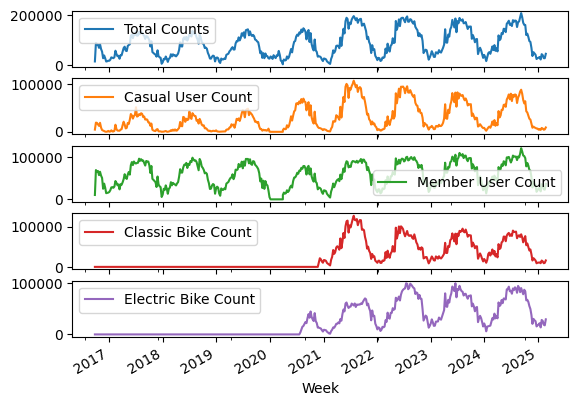

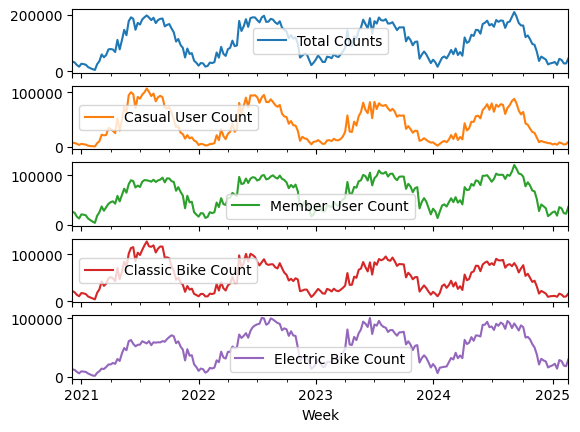

In [102]:
# Features Over Time

plot_cols = ['Total Counts', 'Casual User Count', 'Member User Count',
       'Classic Bike Count', 'Electric Bike Count']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# 220 is the point where Classic Bike Count and Electric Bike Counts start not being 0
plot_features = df[plot_cols][220:]
plot_features.index = date_time[220:]
_ = plot_features.plot(subplots=True)

In [103]:
# Summary Statistics

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Date range:", date_time.min(), "to", date_time.max())
print("Total weeks:", len(df))

Dataset shape: (441, 5)
Columns: ['Total Counts', 'Casual User Count', 'Member User Count', 'Classic Bike Count', 'Electric Bike Count']
Date range: 2016-09-26 00:00:00 to 2025-02-24 00:00:00
Total weeks: 441


In [104]:
# Function to create the time series dataset
def create_sequences(data, seq_length):
    """
    Create sequences of data for time series forecasting
    """
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        # Extract sequence of observations
        seq = data[i:i + seq_length]
        # Extract next value as target
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [105]:
# Get the total counts data
total_counts = df['Total Counts'].values

In [106]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(total_counts.reshape(-1, 1)).flatten()

In [107]:
# Set sequence length (number of weeks to use for prediction)
seq_length = 12
# Using 12 weeks of historical data to predict each future week

# Create sequences
X, y = create_sequences(scaled_data, seq_length)
# Reshape for CNN input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

Using 12 weeks of historical data to predict each future week


In [108]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 343, Testing samples: 86


In [109]:
# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [112]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [114]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - val_loss: 0.0230
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - val_loss: 0.0389
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - val_loss: 0.0369
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - val_loss: 0.0190
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - val_loss: 0.0164
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - val_loss: 0.0218
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - val_loss: 0.0170
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - val_loss: 0.0207
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0261
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - val_loss: 0.0130
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - val_l

In [115]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTrain MSE: {train_loss:.4f}")
print(f"Test MSE: {test_loss:.4f}")


Train MSE: 0.0081
Test MSE: 0.0130


In [116]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calculate error metrics
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"\nModel Performance Metrics:")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Model Performance Metrics:
Root Mean Squared Error: 23432.39
Mean Absolute Error: 18873.68
Mean Absolute Percentage Error: 19.84%


The CNN model performs decently as the error metrics are relatively reasonable. The model performs similarly to the Prophet Model, as the MAPE difference are ~3% and MAE and RMSE are in the 10,000s range. Though the model could not estimate the test peaks and often underestimates the total counts.

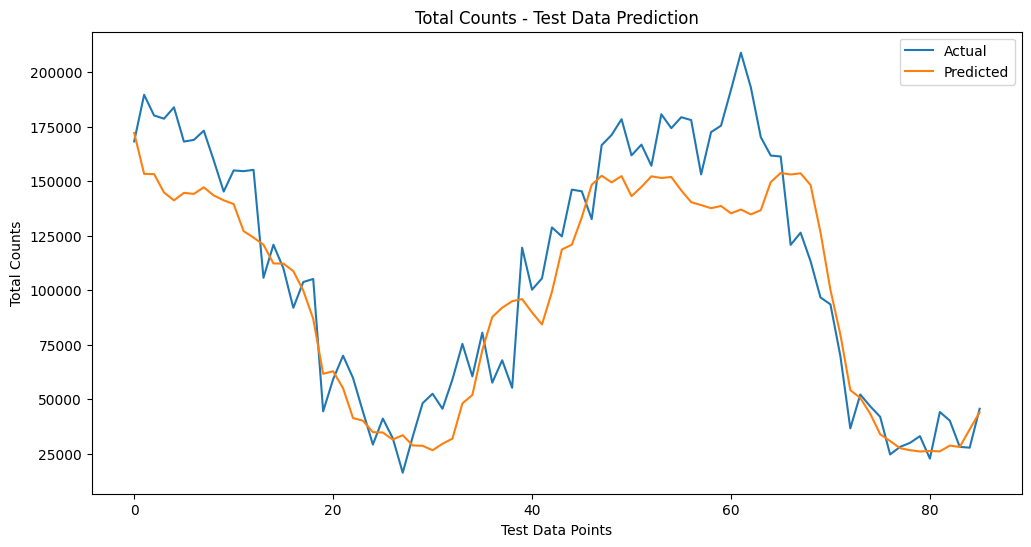

In [118]:
# Plot prediction vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Total Counts - Test Data Prediction')
plt.xlabel('Test Data Points')
plt.ylabel('Total Counts')
plt.legend()
plt.show()

In [122]:
# Forecast the next 52 weeks
n_future_weeks = 52
forecast_values = []

# Use the last sequence from our data as the starting point
current_batch = scaled_data[-seq_length:].reshape(1, seq_length, 1)

In [123]:
for _ in range(n_future_weeks):
    # Get prediction for next week
    next_pred = model.predict(current_batch, verbose=0)[0][0]

    # Add the prediction to our forecast list
    forecast_values.append(next_pred)

    # Update the sequence for the next prediction - fixing the dimension issue
    # Remove the first value and add the new prediction at the end
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = next_pred


In [124]:
# Convert forecast values back to original scale
forecast_inv = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1)).flatten()

# Create future dates
last_date = date_time.iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=n_future_weeks, freq='W')


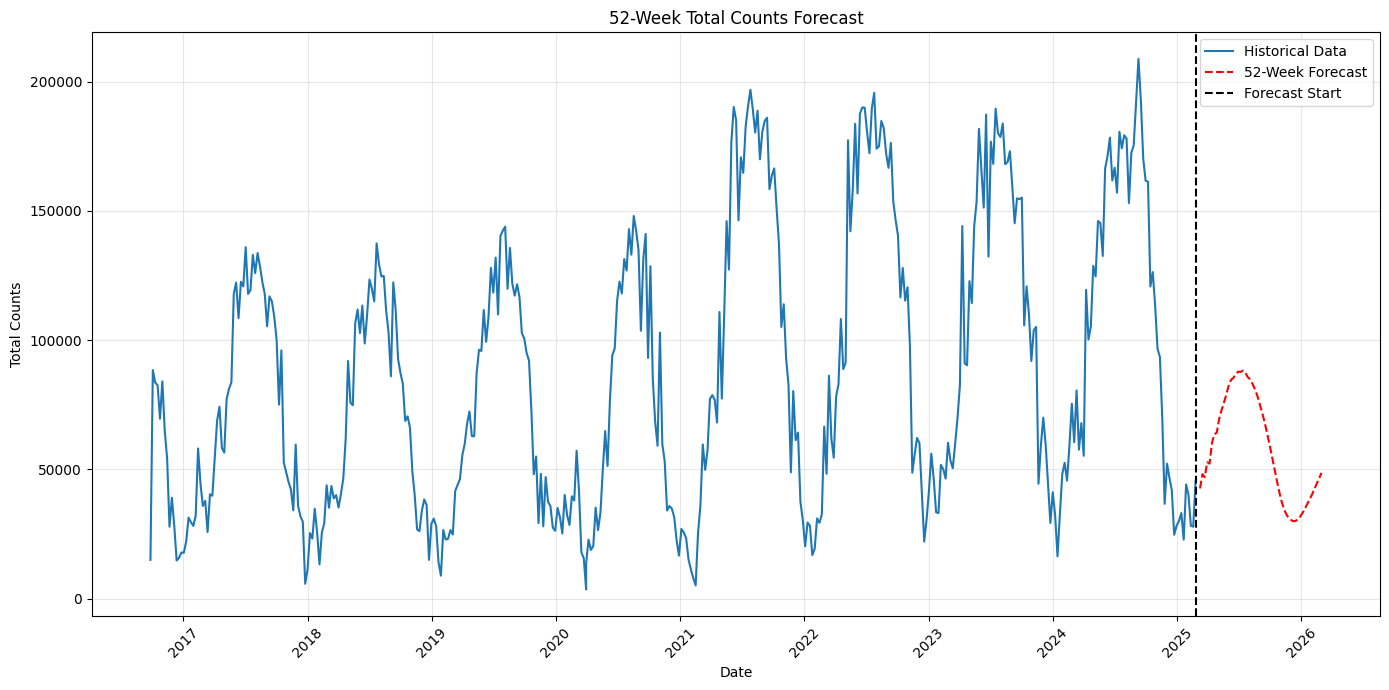

In [125]:
# Plot the forecast with historical data
plt.figure(figsize=(14, 7))
plt.plot(date_time, total_counts, label='Historical Data')
plt.plot(future_dates, forecast_inv, 'r--', label='52-Week Forecast')
plt.axvline(x=last_date, color='k', linestyle='--', label='Forecast Start')
plt.title('52-Week Total Counts Forecast')
plt.xlabel('Date')
plt.ylabel('Total Counts')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

The forecast of the 2025 - 2026 data from the CNN model doesn't seem to be able to gather/follow the trend of the previous years and seems to again underestimate the total counts, making it a poor generalization model from an inital look.

